In [348]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf_lib
import sf_lib.sf
import sf_lib.df
reload(sf_lib), reload(sf_lib.sf), reload(sf_lib.df)

(<module 'sf_lib' from '../..\\sf_lib\\__init__.py'>,
 <module 'sf_lib.sf' from '../..\\sf_lib\\sf.py'>,
 <module 'sf_lib.df' from '../..\\sf_lib\\df.py'>)

In [349]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from datetime import date

import sys
sys.path.append('../..')

from sf_lib.df import extract_task_value, extractTaskValue, json_parser, make_df_classify, make_df_tasks_with_props
from sf_lib.sf import (
    get_running_vote_fraction,
    getFilename, 
    getMetadataValue, 
    parseTime, 
    getGroupSize, 
    extractTaskValue
)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [350]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')

In [351]:
task_indices_hardcore = [0, 2, 1, 3, 4, 5, 9]

In [353]:
converters = {}
for col in ['annotations']:
    converters[col] = json_parser

In [354]:
df = make_df_classify('onthego', [0])

In [8]:
df_votes = make_df_tasks_with_props(df, candidate_names_classify, object_info, onthego=True)

In [356]:
df_classify = make_df_classify('classify', [0,1])
df_hardcore = make_df_classify('hardcore', task_indices_hardcore)

df_votes_clas = make_df_tasks_with_props(df_classify, candidate_names_classify, object_info, onthego=False)

## Make various queries:

In [357]:
in_catalogue = df_votes.query("name.isin(@catalogue_targets)")
cols = ['% votes Galaxy', '% votes Group of objects (cluster)', '% votes Something else/empty center']

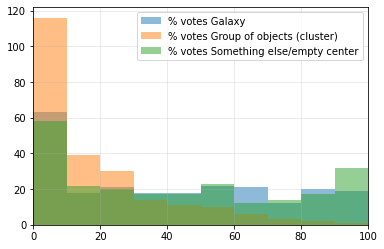

In [358]:
fig, fr = plt.subplots()

for i in range(3):
    fr.hist(in_catalogue[cols[i]], alpha=0.5, label=cols[i])

    
fr.set_xlim(0, 100)
fr.legend()
fr.grid(alpha=0.3, which='both')

In [47]:
def plot_votes_per_user_histogram(cls_per_user_list, labels):
    fig, fr = plt.subplots(1,2, figsize=(12,4))
    
    for index, cls_per_user in enumerate(cls_per_user_list):
        fr[0].hist(cls_per_user, bins=50, alpha=0.4, label=labels[index])
        fr[1].hist(cls_per_user, bins=50, range=[0,200], alpha=0.4, label=labels[index])

    for idx in range(2):
        fr[idx].grid(alpha=0.3, which='both')
        fr[idx].update({
            'xlabel': '# votes per user',
            'ylabel': '# users',
            'xlim': (0)
        })
        fr[idx].legend()

    plt.show()

In [257]:
def plot_running_vote_fraction(data):
    fig, fr = plt.subplots(1,2, figsize=(12,4.5))

    scales = ['linear', 'log']

    for index, _ in enumerate(data):
        counts, running_fraction, label = data[index].values()
        for i in range(len(fr)):
            fr[i].plot(counts, running_fraction, label=label)

    for i in range(len(fr)):
        fr[i].update({
            'xlabel': r'$n$',
            'ylabel': 'Cumulative vote fraction',
            'xscale': scales[i],
            'xlim': (0),
            'ylim': (0,1)
        })

        fr[i].grid(which='both', alpha=0.3)
        fr[i].legend()
    
    fig.suptitle("Fraction of votes cast by all users that made at least $n$ classifications")
    
    plt.savefig('running vote fraction.png', dpi=350)
    plt.show()

In [16]:
fraction_classify = get_running_vote_fraction(df_classify)
fraction_onthego = get_running_vote_fraction(df)
fraction_hc = get_running_vote_fraction(df_hardcore)

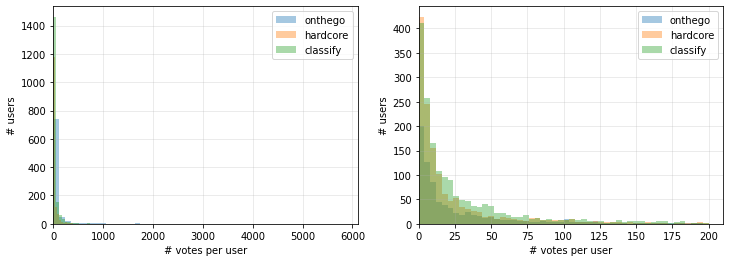

In [360]:
fraction_onthego = get_running_vote_fraction(df)
plot_votes_per_user_histogram([
    fraction_onthego[1],
    fraction_hc[1],
    fraction_classify[1]
], ['onthego', 'hardcore', 'classify'])

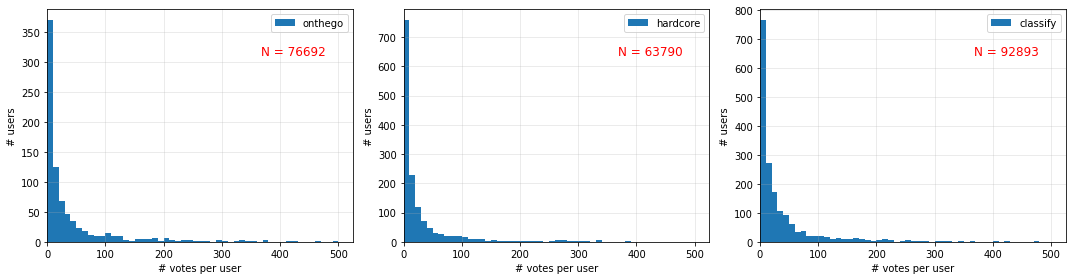

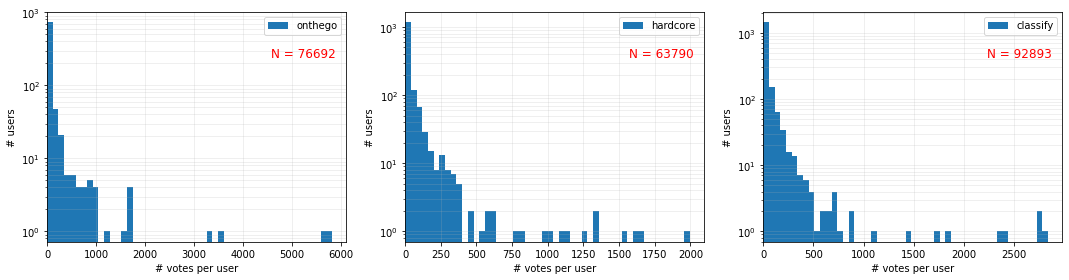

In [361]:
fig, fr = plt.subplots(1,3,figsize=(15,4))

cls_per_user_list = [fraction_onthego[1],fraction_hc[1],fraction_classify[1]]
labels = ['onthego','hardcore','classify']

for i, cls_per_user in enumerate(cls_per_user_list):
    fr[i].hist(cls_per_user, bins=50, range=[0,500], alpha=1, label=labels[i])

    fr[i].grid(alpha=0.3, which='both')
    fr[i].update({
        'xlabel': '# votes per user',
        'ylabel': '# users',
        'xlim': (0)
    })
    fr[i].legend()
    fr[i].text(0.7, 0.8, 'N = {}'.format(sum(cls_per_user)), c='red', size=12, transform=fr[i].transAxes)

plt.tight_layout()

fig, fr = plt.subplots(1,3,figsize=(15,4))
for i, cls_per_user in enumerate(cls_per_user_list):
    fr[i].hist(cls_per_user, bins=50, alpha=1, label=labels[i])

    fr[i].grid(alpha=0.25, which='both')
    fr[i].update({
        'xlabel': '# votes per user',
        'ylabel': '# users',
        'xlim': (0),
        'yscale': 'log'
    })
    fr[i].legend()
    fr[i].text(0.75, 0.8, 'N = {}'.format(sum(cls_per_user)), c='red', size=12, transform=fr[i].transAxes)

plt.tight_layout()
# plt.savefig('user vote counts.png', dpi=350)
plt.show()


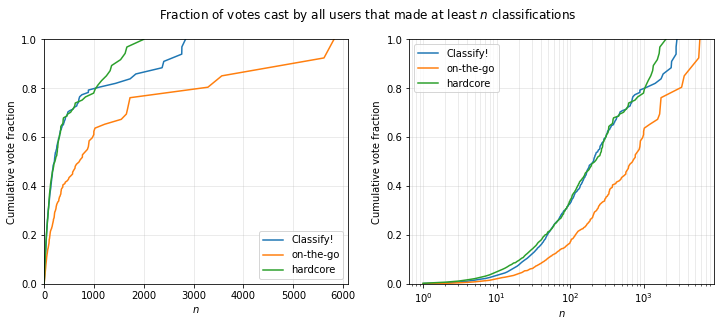

In [258]:
plot_running_vote_fraction([
    {
        'counts': fraction_classify[2],
        'running_fraction': fraction_classify[3],
        'label': 'Classify!'
    },
    {
        'counts': fraction_onthego[2],
        'running_fraction': fraction_onthego[3],
        'label': 'on-the-go'
    },
    {
        'counts': fraction_hc[2],
        'running_fraction': fraction_hc[3],
        'label': 'hardcore'
    }
    
])

In [19]:
dfs = [df_hardcore, df_classify, df]

In [362]:
# get a list of all users in each workflow
users = []
for df in dfs:
    users.append(list(set(df['user_name'])))    

In [363]:
# three pairs of indices, to find user intersection in each combination of workflows
indices = [[0,1], [0,2], [1,2]]

user_overlap = []
for pair in indices:
    i, j = pair
    user_overlap.append(list(set(users[i]) & set(users[j])))

In [364]:
for i in range(3):
    print(len(user_overlap[i]))

191
145
149


So 
- 191 are in both hardcore and classify,
- 145 are in both hardcore and onthego,
- 149 are in both classify and onthego

In [24]:
# check overlap in [0,1], so between hardcore and classify
objects_per_user = []

i,j = indices[0]
for user in user_overlap[0]:
    objects = []
    
    class_i = dfs[i][['Filename', 'user_name', 'T0']].query("user_name == @user")
    class_j = dfs[j][['Filename', 'user_name', 'T0']].query("user_name == @user")
    
    objects_i = class_i['Filename'].values
    objects_j = class_j['Filename'].values
    
    object_overlap = list(set(objects_i) & set(objects_j))
    
    values_match = []
    for obj in object_overlap:
        i_val = class_i.query('Filename == @obj')['T0'].values
        j_val = class_j.query('Filename == @obj')['T0'].values
        values_match.append(i_val[0] == j_val[0])
    
    objects_per_user.append({
        'user': user,
        'objects': list(zip(object_overlap, values_match))
    })

In [366]:
objects_per_user[1]

{'user': 'Galel', 'objects': [('UDGcand_2195', True)]}

In [26]:
agrees_with_self_fraction = []

for entry in objects_per_user:
    user = entry['user']
    objects = entry['objects']
    
    match = [val[1] for val in objects]
    if len(match) > 0:
        agrees_with_self_fraction.append([user, len(match), match.count(True)/len(match)])

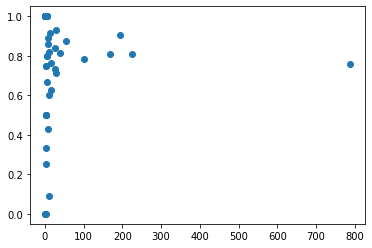

In [27]:
usernames, overlap_count, agree_fraction = np.array(agrees_with_self_fraction).T

overlap_count = overlap_count.astype('float')
agree_fraction = agree_fraction.astype('float')

plt.scatter(overlap_count, agree_fraction)


## (for thesis) unique user count

In [34]:
unique_users = set.union(set(df['user_name']), set(df_classify['user_name']), set(df_hardcore['user_name']))
len(unique_users)

3700

In [36]:
match = 'not-logged-in-'
no_account_count = 0

for user in unique_users:
    if match in user:
        no_account_count += 1

In [38]:
len(unique_users) - no_account_count

2136

In [42]:
sum([df.shape[0], df_classify.shape[0], df_hardcore.shape[0]])

233375

In [46]:
for df in dfs:
    print(df.query('~T0.isnull()').shape[0])

63790
92893
76692


## (for thesis) Vote count per object per workflow 

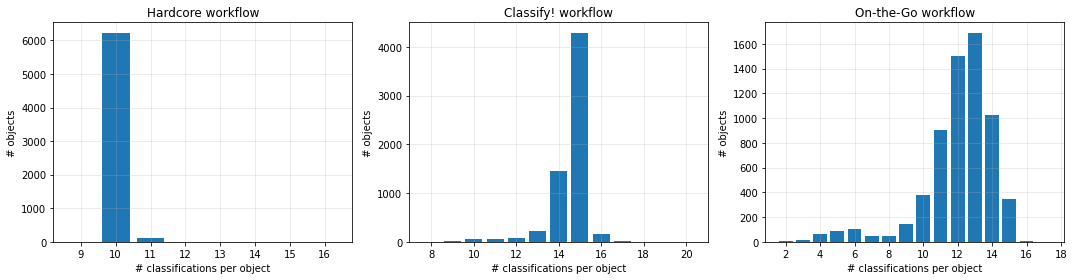

In [253]:
def plot_votecount(_df, title, fr=None):
    classifications_per_object = []

    for name, group in _df.groupby('Filename'):
        classifications_per_object.append(len(group))

    counts = {k: classifications_per_object.count(k) for k in set(classifications_per_object)}
    labels, counts = np.unique(classifications_per_object, return_counts=True)

    if not fr:
        fig, fr = plt.subplots(figsize=(7,4))
        
    fr.bar(labels, counts, align='center')
    fr.grid(alpha=0.3, which='both')
    fr.set_xlabel('# classifications per object')
    fr.set_ylabel('# objects')
    fr.set_title(title)

    if not fr:
        plt.show()
    
    return counts

fig, fr = plt.subplots(1,3, figsize=(15,4))
for i, (df, title) in enumerate(zip(dfs, ['Hardcore workflow', 'Classify! workflow', 'On-the-Go workflow'])):
    plot_votecount(df, title, fr[i])
    
fig.tight_layout()

plt.savefig('votes per object per category.png', dpi=350)
plt.show()

## (for thesis): unique task descriptions and answers

Tasks per category: 
- onthego: [0]
- classify: [0, 1]
- hardcore:[0, 2, 1, 3, 4, 5, 9]

In [421]:
hardcore_tasks = [0,2,1,3,4,5,9]

annot = []
for i in hardcore_tasks:
    task = 'T{}'.format(i)
    annot.append(df_hardcore.query("~{}.isnull()".format(task)).head(1).iloc[0]['annotations'])

In [424]:
tasks_in_workflow = set([(j['task'], j['task_label']) for i in annot for j in i])

In [431]:
for t, desc in tasks_in_workflow:
    print('{} | {} \n Answers: {}\n'.format(t, desc, list(df_hardcore['{}'.format(t)].unique())))

T5 | How would you describe the texture of the galaxy? 
 Answers: [None, 'Smooth and fuzzy', 'Smooth and dense', 'Clumpy and/or featured']

T0 | Look at the very center of the image: do you see a single galaxy or a group of far away objects?  
 Answers: ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

T4 | What shape is the galaxy? 
 Answers: ['Distorted/disturbed', 'Elliptical', None, 'Round']

T9 | Our bad! what do you see instead? 
 Answers: [None, 'Something else', 'Looks like a small star', 'Scattered light', 'Nothing: background too bright or galaxy too faint']

T1 | What color is the galaxy? 
 Answers: ['Impossible to say', 'White/blue', None, 'Red/yellow']

T3 | Does the galaxy have a visible core? 
 Answers: ['No/Unsure', None, 'Yes, a bright point', 'Yes, a bulge']

T2 | Is the galaxy fluffy or is it bright? 
 Answers: ['Fluffy', None, 'Bright']



In [477]:
for t in ['T{}'.format(task) for task in hardcore_tasks]:
    print(t, df_hardcore.query("~T0.isnull()")[t].unique())

T0 ['Galaxy' 'Group of objects (Cluster)' 'Something else/empty center']
T2 ['Fluffy' None 'Bright']
T1 ['Impossible to say' 'White/blue' None 'Red/yellow']
T3 ['No/Unsure' None 'Yes, a bright point' 'Yes, a bulge']
T4 ['Distorted/disturbed' 'Elliptical' None 'Round']
T5 [None 'Smooth and fuzzy' 'Smooth and dense' 'Clumpy and/or featured']
T9 [None 'Something else' 'Looks like a small star' 'Scattered light'
 'Nothing: background too bright or galaxy too faint']


In [478]:
df_hardcore.query("(T0 == 'Galaxy')")

,Filename,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,expert,...,annotations,subject_data,subject_ids,T0,T2,T1,T3,T4,T5,T9
5939,UDGcand_6260,281654598,YelenaK,2173685.0,59cc3d450af2cb56f63e,14226,Classify! Hardcore edition,99.144,2020-10-20 04:25:18+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'43857828': {'retired': None, 'Filename': 'UD...",43857828,Galaxy,Fluffy,Impossible to say,No/Unsure,Distorted/disturbed,None,None
5940,UDGcand_2237,281654744,YelenaK,2173685.0,59cc3d450af2cb56f63e,14226,Classify! Hardcore edition,99.144,2020-10-20 04:26:25+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'43848698': {'retired': None, 'Filename': 'UD...",43848698,Galaxy,Fluffy,White/blue,No/Unsure,Elliptical,Smooth and fuzzy,None
5942,UDGcand_2621,281654797,YelenaK,2173685.0,59cc3d450af2cb56f63e,14226,Classify! Hardcore edition,99.144,2020-10-20 04:26:49+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'43849173': {'retired': None, 'Filename': 'UD...",43849173,Galaxy,Fluffy,White/blue,"Yes, a bright point",Round,Smooth and fuzzy,None
5944,UDGcand_1211,281654888,YelenaK,2173685.0,59cc3d450af2cb56f63e,14226,Classify! Hardcore edition,99.144,2020-10-20 04:27:33+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'43843688': {'retired': None, 'Filename': 'UD...",43843688,Galaxy,Fluffy,Red/yellow,"Yes, a bright point",Distorted/disturbed,Smooth and fuzzy,None
5948,UDGcand_231,281785146,rcuthomas,2033649.0,fcc23d63a6b18a82805f,14226,Classify! Hardcore edition,99.144,2020-10-20 18:40:59+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'50756806': {'retired': {'id': 71297686, 'wor...",50756806,Galaxy,Fluffy,Red/yellow,"Yes, a bright point",Round,Smooth and dense,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70183,UDGcand_2029,301142220,ElisabethB,123.0,bb6e4d7c0e5feaa826dc,14226,Classify! Hardcore edition,99.144,2021-01-12 11:41:56+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'52471556': {'retired': {'id': 74121047, 'wor...",52471556,Galaxy,Fluffy,Red/yellow,No/Unsure,Round,Smooth and fuzzy,None
70184,UDGcand_2045,301142249,ElisabethB,123.0,bb6e4d7c0e5feaa826dc,14226,Classify! Hardcore edition,99.144,2021-01-12 11:42:12+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'52471597': {'retired': {'id': 74124305, 'wor...",52471597,Galaxy,Bright,Red/yellow,"Yes, a bulge",Round,Smooth and dense,None
70185,UDGcand_2029,301142365,not-logged-in-7eba68601ee83b6994c0,NaN,7eba68601ee83b6994c0,14226,Classify! Hardcore edition,99.144,2021-01-12 11:42:59+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'52471556': {'retired': {'id': 74121047, 'wor...",52471556,Galaxy,Fluffy,Red/yellow,No/Unsure,Round,Smooth and fuzzy,None
70217,UDGcand_1418,301151495,acoote,2149532.0,e755fc4e33eaf40485d9,14226,Classify! Hardcore edition,99.144,2021-01-12 13:04:07+00:00,NaN,...,"[{'task': 'T0', 'task_label': 'Look at the ver...","{'52469800': {'retired': {'id': 74138543, 'wor...",52469800,Galaxy,Bright,White/blue,"Yes, a bright point",Round,Smooth and dense,None


In [456]:
'123'.index('2')

1

## (for thesis): Comparison of T0 answers per object between `classify` and `onthego`

In [374]:
# @todo: turn this into hash table instead of double loop

gal_points = []
group_points = []
else_points = []

q = '% votes Galaxy'
q_group_1 = '% votes Group of objects (cluster)'
q_group_2 = '% votes Group of objects (Cluster)'
q_else = '% votes Something else/empty center'
for name in df_votes['name']:
    classify_entry = df_votes_clas.query('name == @name')
    onthego_entry = df_votes.query('name == @name')
    
    classify_galaxy_percentage = classify_entry[q].values[0]
    onthego_galaxy_percentage = onthego_entry[q].values[0]
    
    gal_points.append((classify_galaxy_percentage, onthego_galaxy_percentage))
    group_points.append((classify_entry[q_group_2].values[0], onthego_entry[q_group_1].values[0]))
    else_points.append((classify_entry[q_else].values[0], onthego_entry[q_else].values[0]))

Correlation galaxy votes: 0.9026500094460178
Correlation cluster/group of objects votes: 0.8837399061572347
Correlation empty center votes: 0.9280925946977485


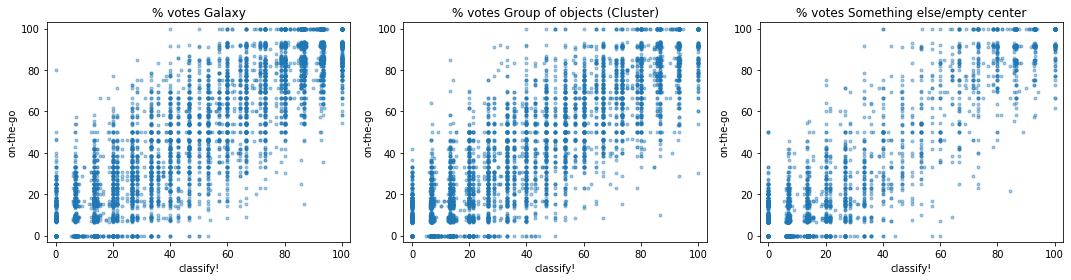

In [390]:
fig, fr = plt.subplots(1,3,figsize=(15,4))
xs = []; ys = []
for point in gal_points:
    x, y = point
    xs.append(x)
    ys.append(y)
    
fr[0].scatter(xs, ys, alpha=0.4, s=9)
print('Correlation galaxy votes:', np.corrcoef(xs, ys)[0,1])

xs = []; ys = []
for point in group_points:
    x, y = point
    xs.append(x)
    ys.append(y)
fr[1].scatter(xs, ys, alpha=0.4, s=9)
print('Correlation cluster/group of objects votes:', np.corrcoef(xs, ys)[0,1])

xs = []; ys = []
for point in else_points:
    x, y = point
    xs.append(x)
    ys.append(y)
fr[2].scatter(xs, ys, alpha=0.4, s=9)
print('Correlation empty center votes:', np.corrcoef(xs, ys)[0,1])

for i, col in enumerate([q, q_group_2, q_else]):
    fr[i].update({
        'xlim': [-3,103],
        'ylim': [-3,103],
        'xlabel': 'classify!',
        'ylabel': 'on-the-go',
        'title': col
    })
#     fr[i].grid(alpha=0.3, which='both')

fig.tight_layout()

# plt.savefig('task0 classify vs onthego.png', dpi=350)
plt.show()